# Master model development

## John Brandt

### Last updated: November 1 2019

*  Package loading
*  Hyperparameter definitions
*  Additional layer definitions
*  Model definition
*  Data loading
*  Data preprocessing
*  K means clustering
*  Augment training data
*  Loss definition
*  Equibatch creation
*  Model training
*  Model validation and sanity checks

In [1]:
# Notes
# The model is very sensitive to zoneout prob, do not go above 0.05
# AdaBound seems to perform worse, stick to Adam with step down loss
# 32 x 24 x 32 model overfits after 100 epochs
# Investigate more hypercolumn parametrizations to increase available data at output 
#    while maintaining low dimensionality of filters
# 5e-4 LR worked, investigating 8e-4 for 60% faster training time
# ONLY CHANGE ONE THING AT A TIME

In [2]:
#TODO Remove imports that aren't needed to save RAM
from tqdm import tqdm_notebook, tnrange
import tensorflow as tf

sess = tf.Session()
from keras import backend as K
K.set_session(sess)

import keras
from tensorflow.python.keras.layers import *
from tensorflow.python.keras.layers import ELU
from keras.losses import binary_crossentropy
from tensorflow.python.ops import array_ops
from tensorflow.python.keras.layers import Conv2D, Lambda, Dense, Multiply, Add, Bidirectional, ConvLSTM2D

import tensorflow.contrib.slim as slim
from tensorflow.contrib.slim import conv2d

import pandas as pd
import numpy as np
from random import shuffle
import pandas as pd
import seaborn as sns
import matplotlib.pyplot as plt
%matplotlib inline
import os
import itertools
from tflearn.layers.conv import global_avg_pool
from tensorflow.contrib.framework import arg_scope
from keras.regularizers import l1
from tensorflow.layers import batch_normalization
from tensorflow.python.util import deprecation as deprecation
deprecation._PRINT_DEPRECATION_WARNINGS = False

os.environ['KMP_DUPLICATE_LIB_OK']='True'

Using TensorFlow backend.


Instructions for updating:
Colocations handled automatically by placer.


In [3]:
%run ../src/zoneout.py
%run ../src/convgru.py
%run ../src/lovasz.py
%run ../src/utils.py
%run ../src/adabound.py
%run ../src/slope.py
%run ../src/dropblock.py

# Hyperparameter definitions

In [4]:
ZONE_OUT_PROB = 0.25
L2_REG = 0.0
INITIAL_LR = 2e-4
FINAL_LR = 1e-3
BN_MOMENTUM = 0.9
BATCH_SIZE = 16
TRAIN_RATIO = 0.8
TEST_RATIO = 0.2
MAX_DROPBLOCK = 0.85
INP_FILTERS = 17

gru_flt = 12
fpa_flt = 16
out_conv_flt = 32


AUGMENTATION_RATIO = 4
IMAGE_SIZE = 16
existing = [int(x[:-4]) for x in os.listdir('../data/final/') if ".DS" not in x]
N_SAMPLES = len(existing)

LABEL_SIZE = 14

    
TRAIN_SAMPLES = int((N_SAMPLES * AUGMENTATION_RATIO) * TRAIN_RATIO)
TEST_SAMPLES = int((N_SAMPLES * AUGMENTATION_RATIO) - TRAIN_SAMPLES)
print(TRAIN_SAMPLES // AUGMENTATION_RATIO, N_SAMPLES - (TRAIN_SAMPLES // AUGMENTATION_RATIO))

539 135


# Additional layer definitions

In [5]:
def conv_bn_elu(inp, is_training, kernel_size, scope, filter_count = 16, pad = True, padding = 'valid'):
    if kernel_size == 3:
        if pad:
            padded = ReflectionPadding2D((1, 1,))(inp)
        else:
            padded = inp
        padding = padding
    else:
        padded = inp
        padding = padding
    conv = Conv2D(filters = filter_count, kernel_size = (kernel_size, kernel_size),
                      padding = padding, kernel_initializer = 'he_normal')(padded)
    elu = ELU()(conv)
    bn = Batch_Normalization(elu, training=is_training, scope = scope + "bn")
    return bn

def td_conv_bn_elu(inp, is_training, scope, filter_count = 16, pad = True, padding = 'valid'):
    #padded = TimeDistributed(ReflectionPadding2D((1, 1,)))(inp)
    #padded = tf.pad(inp, [[0,0], [0,0], [1,1], [1,1], [0,0] ], 'REFLECT')
    conv = TimeDistributed(Conv2D(filters = filter_count, kernel_size = (1, 1),
                      padding = 'SAME', kernel_initializer = 'he_normal'))(inp)
    elu = TimeDistributed(ELU())(conv)
    #bn = TimeDistributed(Batch_Normalization(elu, training=is_training, scope = scope + "bn")
    return elu

def resnet_block(inp, is_training, scope, flt):
    drop1 = DropBlock2D(keep_prob = keep_rate, block_size = 3)
    drop2 = DropBlock2D(keep_prob = keep_rate, block_size = 3)
    padded = ReflectionPadding2D((1, 1,))(inp)
    conv1 = Conv2D(filters = flt, kernel_size = (3, 3),
                      padding = 'valid', kernel_initializer = 'he_normal')(padded)
    elu1 = ELU()(conv1)
    bn1 = Batch_Normalization(elu1, training=is_training, scope = scope + "bn1")
    d1 = drop1(bn1, is_training)
    
    pad2 = ReflectionPadding2D((1, 1))(d1)
    conv2 = Conv2D(filters = flt, kernel_size = (3, 3),
                      padding = 'valid', kernel_initializer = 'he_normal')(pad2)
    elu2 = ELU()(conv2)
    bn2 = Batch_Normalization(elu2, training=is_training, scope = scope + "bn2")
    d2 = drop2(bn2, is_training)
    skip = tf.add(inp, d2)
    reweighted = csse_block(skip, scope + "csse")
    return reweighted
    
    
def fpa(inp, is_training, filter_count):
    one = conv_bn_elu(inp, is_training, 1, 'forward1', filter_count, False, 'valid')
    five = conv_bn_elu(inp, is_training, 5, 'down1', filter_count, False, 'valid')
    five_f = conv_bn_elu(five, is_training, 5, 'down1_f', filter_count, False, 'valid')
    three = conv_bn_elu(five, is_training, 3, 'down2', filter_count, False, 'valid')
    three_f = conv_bn_elu(three, is_training, 3, 'down2_f', filter_count, False, 'valid')
    
    three_up = get_deconv2d(three_f, filter_count, filter_count, "fpa1", is_training)
    five_up = get_deconv2d(five_f, filter_count, filter_count, "fpa2", is_training)
    
    print("One: {}".format(one.shape))
    print("Five: {}".format(five.shape))
    print("Five_F: {}".format(five_f.shape))
    print("Three: {}".format(three.shape))
    print("Three_f: {}".format(three_f.shape))
    print("Three_up: {}".format(three_up.shape))
    print("Five_up: {}".format(five_up.shape))
    
    # top block
    pooled = tf.keras.layers.GlobalAveragePooling2D()(inp)
    one_top = conv_bn_elu(tf.reshape(pooled, (-1, 1, 1, pooled.shape[-1])),
                          is_training, 1, 'top1', filter_count)
    four_top = tf.keras.layers.UpSampling2D((16, 16))(one_top)
    
    
    concat_1 = tf.multiply(one, tf.add(three_up, five_up))
    concat_2 = tf.add(concat_1, four_top)
    print("Feature pyramid attention shape {}".format(concat_2.shape))
    return concat_2

    
def create_deconv_init(filter_size, num_channels):
    bilinear_kernel = np.zeros([filter_size, filter_size], dtype=np.float32)
    scale_factor = (filter_size + 1) // 2
    if filter_size % 2 == 1:
        center = scale_factor - 1
    else:
        center = scale_factor - 0.5
    for x in range(filter_size):
        for y in range(filter_size):
            bilinear_kernel[x,y] = (1 - abs(x - center) / scale_factor) * \
                                   (1 - abs(y - center) / scale_factor)
    weights = np.zeros((filter_size, filter_size, num_channels, num_channels))
    for i in range(num_channels):
        weights[:, :, i, i] = bilinear_kernel

    #assign numpy array to constant_initalizer and pass to get_variable
    bilinear_init = tf.constant_initializer(value=weights, dtype=tf.float32)
    return bilinear_init


def get_deconv2d(inp, filter_count, num_channels, scope, is_training):
    bilinear_init = create_deconv_init(4, filter_count)
    x = tf.keras.layers.Conv2DTranspose(filters = filter_count, kernel_size = (4, 4),
                                        strides=(2, 2), padding='same', 
                                        kernel_initializer = bilinear_init)(inp)
    x = ELU()(x)
    x = Batch_Normalization(x, training=is_training, scope = scope + "bn")
    return x


def Batch_Normalization(x, training, scope):
    return batch_normalization(inputs=x, 
                               momentum = BN_MOMENTUM, 
                               training=training,
                               renorm = True,
                               reuse=None,
                               name = scope)


def attention(inputs, attention_size, time_major=False, return_alphas=False):
    inputs_orig = inputs
    inputs = tf.reduce_mean(inputs, axis = [2, 3])
    #print("ATT means: {}".format(inputs.shape))
    if isinstance(inputs, tuple):
        # In case of Bi-RNN, concatenate the forward and the backward RNN outputs.
        inputs = tf.concat(inputs, 2)

    if time_major:
        # (T,B,D) => (B,T,D)
        inputs = tf.array_ops.transpose(inputs, [1, 0, 2])

    hidden_size = inputs.shape[2].value  # D value - hidden size of the RNN layer

    # Trainable parameters
    w_omega = tf.Variable(tf.random_normal([hidden_size, attention_size], stddev=0.1))
    b_omega = tf.Variable(tf.random_normal([attention_size], stddev=0.1))
    u_omega = tf.Variable(tf.random_normal([attention_size], stddev=0.1))

    with tf.name_scope('v'):
        # Applying fully connected layer with non-linear activation to each of the B*T timestamps;
        #  the shape of `v` is (B,T,D)*(D,A)=(B,T,A), where A=attention_size
        v = tf.tanh(tf.tensordot(inputs, w_omega, axes=1) + b_omega)

    # For each of the timestamps its vector of size A from `v` is reduced with `u` vector
    vu = tf.tensordot(v, u_omega, axes=1, name='vu')  # (B,T) shape
    alphas = tf.nn.softmax(vu, name='alphas')         # (B,T) shape
    print("Alphas: {}".format(alphas.shape))
    # Output of (Bi-)RNN is reduced with attention vector; the result has (B,D) shape
    output = tf.reduce_sum(inputs_orig * tf.reshape(alphas, (-1, 24, 1, 1, 1)), axis = 1)
    #output = tf.reduce_sum(inputs * tf.expand_dims(alphas, -1), 1)
    print(output.shape)
    if not return_alphas:
        return output
    else:
        return output, alphas

def cse_block(prevlayer, prefix):
    mean = Lambda(lambda xin: K.mean(xin, axis=[1, 2]))(prevlayer)
    lin1 = Dense(K.int_shape(prevlayer)[3] // 2, name=prefix + 'cse_lin1', activation='relu')(mean)
    lin2 = Dense(K.int_shape(prevlayer)[3], name=prefix + 'cse_lin2', activation='sigmoid')(lin1)
    x = Multiply()([prevlayer, lin2])
    return x

def temporal_attention(inp, scope):
    # This rescales each output
    # Timesteps that are more important get weighted higher
    # Timesteps that are least important get weighted lower --> B, N, H, W, C
    conved = TimeDistributed(Conv2D(50, (1, 1), padding = 'same', kernel_initializer = 'he_normal',
                            activation = 'tanh', strides = (1, 1)))(inp)
    
    conved = TimeDistributed(Conv2D(1, (1, 1), padding = 'same', kernel_initializer = 'he_normal',
                            activation = 'sigmoid', use_bias = False, strides = (1, 1)))(conved)
    
    # We need to calculate the total sum for each pixel for each channel, so that we can combine them
    conved = conved / tf.reduce_sum(conved, axis = 1, keep_dims=True)
    print("Attention weight shapes {}".format(conved.shape))
    
    # This actually multiplies the Conv by the input
    multiplied = tf.reduce_sum(conved * inp, axis = 1)
    return multiplied
    


def sse_block(prevlayer, prefix):
    conv = Conv2D(1, (1, 1), padding="same", kernel_initializer="he_normal",
                  activation='sigmoid', strides=(1, 1),
                  name=prefix + "_conv")(prevlayer)
    conv = Multiply(name=prefix + "_mul")([prevlayer, conv])
    return conv


def csse_block(x, prefix):
    '''
    Implementation of Concurrent Spatial and Channel ‘Squeeze & Excitation’ in Fully Convolutional Networks
    https://arxiv.org/abs/1803.02579
    '''
    cse = cse_block(x, prefix)
    sse = sse_block(x, prefix)
    x = Add(name=prefix + "_csse_mul")([cse, sse])

    return x

class ReflectionPadding2D(Layer):
    def __init__(self, padding=(1, 1), **kwargs):
        self.padding = tuple(padding)
        self.input_spec = [InputSpec(ndim=4)]
        super(ReflectionPadding2D, self).__init__(**kwargs)

    def compute_output_shape(self, s):
        """ If you are using "channels_last" configuration"""
        return (s[0], s[1] + 2 * self.padding[0], s[2] + 2 * self.padding[1], s[3])

    def call(self, x, mask=None):
        w_pad,h_pad = self.padding
        return tf.pad(x, [[0,0], [h_pad,h_pad], [w_pad,w_pad], [0,0] ], 'REFLECT')
    
    
def gru_block(inp, length, size, flt, scope, train, normalize = True):
    with tf.variable_scope(scope):
        print("GRU input shape {}, zoneout: {}".format(inp.shape, ZONE_OUT_PROB))
        cell_fw = ConvLSTMCell(shape = size, filters = flt,
                           kernel = [3, 3], normalize = normalize)
        cell_bw = ConvLSTMCell(shape = size, filters = flt,
                           kernel = [3, 3], normalize = normalize)
        cell_fw = ZoneoutWrapper(
           cell_fw, zoneout_drop_prob = ZONE_OUT_PROB, is_training = train)
        cell_bw = ZoneoutWrapper(
            cell_bw, zoneout_drop_prob = ZONE_OUT_PROB, is_training = train)
        output, final_state = convGRU(inp, cell_fw, cell_bw, length)
        final_state = tf.concat(final_state, axis = -1)
        output = tf.concat(output, axis = -1)
        print("Hidden output shape: {}".format(output))
        
        attended = temporal_attention(output, "attention")
        #output = output[:, -1, :, :, :]
        #attended = attention(output, 50)
        means = tf.reduce_mean(inp, axis = 1)
        out = tf.concat([attended, means], axis = -1)
        print("GRU Output shape: {}".format(out.shape))
    return out

# Model definition

In [6]:
reg = keras.regularizers.l2(L2_REG)
inp = tf.placeholder(tf.float32, shape=(None, 24, IMAGE_SIZE, IMAGE_SIZE, INP_FILTERS))
length = tf.placeholder(tf.int32, shape = (None, 1))
labels = tf.placeholder(tf.float32, shape=(None, 14, 14))#, 1))
keep_rate = tf.placeholder_with_default(1.0, ())
length2 = tf.reshape(length, (-1,))
is_training = tf.placeholder_with_default(False, (), 'is_training')
    
    
# GRU -> Conv -> Conv
#feature_engineering = td_conv_bn_elu(inp, is_training, 'feats', filter_count = 16, pad = False, padding = 'valid')
#feats = tf.concat([inp, feature_engineering], axis = -1)
gru_output = gru_block(inp = inp, length = length2, size = [16, 16],
                      flt = gru_flt, scope = 'down_16', train = is_training)
gru_conv = conv_bn_elu(gru_output, is_training, 3, 'gru_conv', out_conv_flt, pad = True)
gru_csse1 = csse_block(gru_conv, "csse_conv1")

# Skip -> FPA
drop2 = DropBlock2D(keep_prob = keep_rate, block_size = 3)
drop = drop2(gru_csse1, is_training)

#fpa = fpa(drop, is_training, fpa_flt)
#fpa_csse = csse_block(fpa, 'csse_fpa')
#fpa_skip = tf.concat([fpa_csse, gru_csse1, gru_output], axis = -1)
#drop3 = DropBlock2D(keep_prob = keep_rate, block_size = 3)
#out_drop1 = drop3(fpa_skip, is_training)

# Conv -> Hyperpyramid -> Conv
out_skip = tf.concat([gru_csse1, drop], axis = -1)
out_conv1 = conv_bn_elu(drop, is_training, 3, "out_conv1", out_conv_flt, pad = False)

print("Initializing last sigmoid bias with -2.94 constant")
init = tf.constant_initializer([-np.log(0.9/0.1)]) # For focal loss
fm = Conv2D(filters = 1,
            kernel_size = (1, 1), 
            padding = 'valid',
            activation = 'sigmoid',
            bias_initializer = init,
           )(out_conv1) # For focal loss
print("Output shape: {}".format(fm.shape))

GRU input shape (?, 24, 16, 16, 17), zoneout: 0.25
Hidden output shape: Tensor("down_16/concat_1:0", shape=(?, 24, 16, 16, 24), dtype=float32)
Attention weight shapes (?, 24, 16, 16, 1)
GRU Output shape: (?, 16, 16, 41)
Initializing last sigmoid bias with -2.94 constant
Output shape: (?, 14, 14, 1)


In [7]:
total_parameters = 0
for variable in tf.trainable_variables():
    shape = variable.get_shape()
    variable_parameters = 1
    for dim in shape:
        variable_parameters *= dim.value
    total_parameters += variable_parameters
print("This model has {} parameters".format(total_parameters))

This model has 67382 parameters


# Data loading

In [8]:
df = pd.read_csv("../data/subplot.csv")
df1 = pd.read_csv("../data/subplot2.csv")
df2 = pd.read_csv("../data/subplot3.csv")
df3 = pd.read_csv("../data/subplot4.csv")

df = df.drop('IMAGERY_TITLE', axis = 1).dropna(axis = 0)
df1 = df1.drop('IMAGERY_TITLE', axis = 1).dropna(axis = 0)
df2 = df2.drop('IMAGERY_TITLE', axis = 1).dropna(axis = 0)
df3 = df3.drop('IMAGERY_TITLE', axis = 1).dropna(axis = 0)

lens = [len(x) for x in [df, df1, df2, df3]]

df = pd.concat([df, df1, df2, df3], ignore_index = True)
df = df.dropna(axis = 0)

existing = [int(x[:-4]) for x in os.listdir('../data/correct_dem/') if ".DS" not in x]
N_SAMPLES = len(existing)

In [9]:
df = df[df['PLOT_ID'].isin(existing)]
N_SAMPLES = int(df.shape[0]/196)
N_YEARS = 1

plot_ids = sorted(df['PLOT_ID'].unique())


def reconstruct_images(plot_id):
    subs = df[df['PLOT_ID'] == plot_id]
    rows = []
    lats = reversed(sorted(subs['LAT'].unique()))
    for i, val in enumerate(lats):
        subs_lat = subs[subs['LAT'] == val]
        subs_lat = subs_lat.sort_values('LON', axis = 0)
        rows.append(list(subs_lat['TREE']))
    return rows

data = [reconstruct_images(x) for x in plot_ids]


# Initiate empty lists to store the X and Y data in
data_x, data_y, lengths = [], [], []

# Iterate over each plot
for i in tnrange(len(plot_ids)):
    # Load the sentinel imagery
    for year in ["correct_dem"]:  
        x = np.load("../data/" + year + "/" + str(plot_ids[i]) + ".npy")
        x = ndvi(x, image_size = 16)
        x = evi(x, image_size = 16)
        x = savi(x, image_size = 16)
        x = bi(x)
        x = msavi2(x)
        x = si(x)
        #x = ndmi(x)
        x = remove_blank_steps(x)
        y = reconstruct_images(plot_ids[i])
        x[:, :, :, 10] /= 90
        lengths.append(x.shape[0])
        if x.shape[0] < 24:
            padding = np.zeros((24 - x.shape[0], IMAGE_SIZE, IMAGE_SIZE, 14))
            x = np.concatenate((x, padding), axis = 0)
        data_x.append(x)
        data_y.append(y)
print("Finished data loading")

data_x = np.stack(data_x)
data_y = np.stack(data_y)
lengths = np.stack(lengths)


Finished data loading


In [10]:
np.max(data_x[:, :, :, :, 10])

0.8164800855848524

# Data preprocessing

In [11]:
below_1 = [i for i, val in enumerate(data_x) if np.min(val) < -1.5]
above_1 = [i for i, val in enumerate(data_x) if np.max(val) > 1.5]
min_vals = [np.min(val) for i, val in enumerate(data_x) if np.min(val) < -1.5]
max_vals = [np.max(val) for i, val in enumerate(data_x) if np.max(val) > 1.5]
outliers = below_1 + above_1
print("The outliers are: {}, totalling {}".format(outliers, len(outliers)))
print("\n")
print(min_vals, max_vals)
data_x = data_x[[x for x in range(0, len(data_x)) if x not in outliers]]
data_y = data_y[[x for x in range(0, len(data_y)) if x not in outliers]]
lengths = lengths[[x for x in range(0, len(lengths)) if x not in outliers]]

min_all = []
max_all = []
for x in range(0, data_x.shape[-1]):
    mins, maxs = (np.min(data_x[:, :, :, :, x]), np.max(data_x[:, :, :, :, x]))
    min_all.append(mins)
    max_all.append(maxs)
    
    data_x[:, :, :, :, x] = (data_x[:, :, :, :, x] - mins) / (maxs - mins)
    
print("The data has been scaled to [{}, {}]".format(np.min(data_x), np.max(data_x)))

The outliers are: [7, 45, 141, 195, 292, 324, 327, 336, 363, 382, 385, 440, 497, 549, 601, 610, 652, 661, 7, 195, 225, 318, 487, 497, 634, 661], totalling 26


[-6.321969935282787, -4.535834700871396, -27.47112805642772, -5.6786949197057535, -1.8062032684100147, -1.993483055138996, -4.530147022565086, -154.96879970980808, -9.975800327549234, -28.58520075669514, -2.238301983142812, -11.793600000161678, -738.3066513950349, -7.680050306753378, -5.0765703897432335, -4.257098714871306, -4.458718742819538, -1191.1332383574356] [5.0, 5.0, 5.0, 5.0, 5.0, 4291.504339112331, 5.0, 144.11851966358546]
The data has been scaled to [0.0, 1.0]


In [12]:
plot_ids2 = [val for x, val in enumerate(plot_ids) if x not in list(set([x for x in outliers]))]
N_SAMPLES = len(data_x)

region_lengths = []
for x in [df1, df2, df3]:
    subs = [i for i in set(x['PLOT_ID']) if i in plot_ids2]
    region_lengths.append(len(subs))
    
region_lengths = [N_SAMPLES - sum(region_lengths)] + region_lengths

print("The region sample distribution is {}".format(region_lengths))
print(sum(region_lengths))
train_ordering = []
test_ordering = []
ordering = []
total_samples = 0
for r in TRAIN_RATIO, TEST_RATIO:
    for i, val in enumerate(region_lengths):
        start = int(np.sum(region_lengths[:i]))
        end = start + val
        if r == 0.8:
            start = start
            end = end-((end-start)*(1-r))
            start = int(start)
            end = int(end)
            total_samples += (end - start)
            train_ordering += [x for x in range(start, end)]
        if r == 0.2:
            start = start + ((end-start)*(1-r))
            end = end
            start = int(start)
            end = int(end)
            total_samples += (end-start)
            test_ordering += [x for x in range(start, end)]

ordering = train_ordering + test_ordering

data_x = data_x[ordering]
data_y = data_y[ordering]
lengths = lengths[ordering]

The region sample distribution is [196, 131, 149, 184]
660


# K Means clustering

In [13]:
from sklearn.cluster import KMeans

NONZERO_CLUSTERS = 10
ZERO_CLUSTERS = 6

kmeans = KMeans(n_clusters=NONZERO_CLUSTERS, random_state = 50)
kmeans_zero = KMeans(n_clusters = ZERO_CLUSTERS, random_state = 50)
unaugmented = [x for x in range(0, len(data_y))]
zeros = [x for x in unaugmented if np.sum(data_y[x]) == 0]
nonzero = [x for x in unaugmented if x not in zeros]
kmeans.fit(data_y[nonzero, :, :].reshape((len(nonzero), 14*14)))
kmeans_zero.fit(np.mean(data_x[zeros, :, :], axis = 1).reshape((len(zeros), 16*16*INP_FILTERS)))             

KMeans(algorithm='auto', copy_x=True, init='k-means++', max_iter=300,
       n_clusters=6, n_init=10, n_jobs=None, precompute_distances='auto',
       random_state=50, tol=0.0001, verbose=0)

In [14]:
def multiplot(matrices):
    '''Plot multiple heatmaps with subplots'''
    fig, axs = plt.subplots(ncols=4)
    fig.set_size_inches(20, 4)
    for i, matrix in enumerate(matrices):
        sns.heatmap(data = matrix, ax = axs[i], vmin = 0, vmax = 0.9)
        axs[i].set_xlabel("")
        axs[i].set_ylabel("")
        axs[i].set_yticks([])
        axs[i].set_xticks([])
    plt.show()

[143, 236, 348, 486]


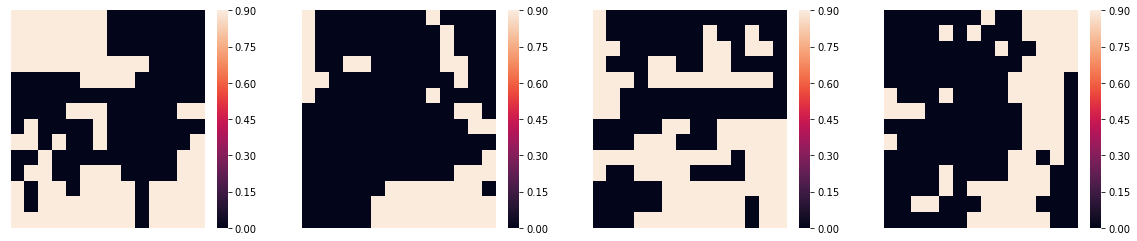

In [15]:
import random 
samples_x = [val for x, val in enumerate(nonzero) if kmeans.labels_[x] == 1]
print(samples_x)
randoms = random.sample(samples_x, 4)
randoms = [data_y[x] for x in randoms]
randoms = [x.reshape((14, 14)) for x in randoms]
multiplot(randoms)

In [16]:
percs = np.sum(data_y.reshape((-1, 14*14)), axis = 1)
idx = [x for x in range(0, len(data_y))]
print([i for x, i in enumerate(sorted(percs)) if x % (len(data_y)//15) == 0 ])

ids = {
    0: [x for x, z in zip(idx, percs) if 0 < z <= 5],
    1: [x for x, z in zip(idx, percs) if 5 < z <= 9],
    2: [x for x, z in zip(idx, percs) if 9 < z <= 14],
    3: [x for x, z in zip(idx, percs) if 14 < z <= 19],
    4: [x for x, z in zip(idx, percs) if 19 < z <= 27],
    5: [x for x, z in zip(idx, percs) if 27 < z <= 33],
    6: [x for x, z in zip(idx, percs) if 33 < z <= 41],
    7: [x for x, z in zip(idx, percs) if 41 < z <= 56],
    8: [x for x, z in zip(idx, percs) if 56  < z <= 93],
    9: [x for x, z in zip(idx, percs) if 93 < z <= 120],
    10: [x for x, z in zip(idx, percs) if 120 < z]
}

[0.0, 0.0, 0.0, 0.0, 0.0, 1.0, 5.0, 9.0, 14.0, 19.0, 27.0, 32.0, 41.0, 56.0, 93.0]


In [17]:
def balance_data(data_y, ids, labels, labels2, unaugmented = unaugmented):
    # Loop over the nonzero clusters
    #for i in range(0, NONZERO_CLUSTERS):
    #    tmp = [val for x, val in enumerate(nonzero) if labels[x] == i]
    #    ids[i] = tmp
    # Loop over the zero clusters
    for i in range(0, ZERO_CLUSTERS):
        tmp = [val for x, val in enumerate(zeros) if labels2[x] == i]
        ids[i + 11] = tmp
    #ids[10] = zeros
    return ids



In [18]:
ids = balance_data(data_y, ids, kmeans.labels_, kmeans_zero.labels_ )
items = [v for k, v in ids.items()]
items = [item for sublist in items for item in sublist]
print("The {} samples have been balanced between the sampling sites".format(len(items)))

The 660 samples have been balanced between the sampling sites


In [19]:
train_ids = []
test_ids = []
for i in ids:
    ln = len(ids[i])
    train_len = int(np.floor([ln * TRAIN_RATIO]))
    test_len = ln - train_len
    print(train_len, test_len, ln)
    trains = ids[i][:train_len]
    tests = ids[i][train_len:]
    train_ids += trains
    test_ids += tests
    
train_labels = []
for i in train_ids:
    train_labels.append([k for k, v in ids.items() if i in v][0])

45 12 57
36 10 46
33 9 42
36 10 46
36 9 45
33 9 42
36 9 45
32 8 40
35 9 44
12 3 15
21 6 27
38 10 48
8 2 10
36 10 46
28 7 35
32 9 41
24 7 31


In [20]:
print("Train and test characteristics:")
print("Train mean Y {}".format(np.mean([np.sum(x) for x in data_y[train_ids]])))
print("Test mean Y {}".format(np.mean([np.sum(x) for x in data_y[test_ids]])))
print("Train STD Y {}".format(np.std([np.sum(x) for x in data_y[train_ids]])))
print("Test STD Y {}".format(np.std([np.sum(x) for x in data_y[test_ids]])))
print("Train number with zero trees {}".format(0.2*len([x for x in data_y[train_ids] if np.sum(x) == 0])))
print("Test number with zero trees {}".format(0.8*len([x for x in data_y[test_ids] if np.sum(x) == 0])))
print("Train mean NDVI")
print("Test mean NDVI")
print("There are {} train and {} test samples".format(len(train_ids), len(test_ids)))
print("There is {} overlap between train and test".format(len([x for x in train_ids if x in test_ids])))


Train and test characteristics:
Train mean Y 25.456813819577736
Test mean Y 25.85611510791367
Train STD Y 37.17885593737099
Test STD Y 40.8012485968982
Train number with zero trees 33.2
Test number with zero trees 36.0
Train mean NDVI
Test mean NDVI
There are 521 train and 139 test samples
There is 0 overlap between train and test


# Augment training data

In [21]:
data_x_augmented = []
data_y_augmented = []
lengths_augmented = []
labels_augmented = []
for i, val in enumerate(train_ids):
    data_x_augmented.append(data_x[val])
    data_y_augmented.append(data_y[val])
    lengths_augmented.append(data_x[val].shape[0])
    labels_augmented.append(train_labels[i])
    
    x1 = np.flip(data_x[val], 1)
    y1 = np.flip(data_y[val], 0)
    lengths_augmented.append(x1.shape[0])
    labels_augmented.append(train_labels[i])
    data_x_augmented.append(x1)
    data_y_augmented.append(y1)
    
    x1 = np.flip(data_x[val], [2, 1])
    y1 = np.flip(data_y[val], [1, 0])
    lengths_augmented.append(x1.shape[0])
    labels_augmented.append(train_labels[i])
    data_x_augmented.append(x1)
    data_y_augmented.append(y1)
    
    x1 = np.flip(data_x[val], 2)
    y1 = np.flip(data_y[val], 1)
    lengths_augmented.append(x1.shape[0])
    labels_augmented.append(train_labels[i])
    data_x_augmented.append(x1)
    data_y_augmented.append(y1)

train_x = np.stack(data_x_augmented)
train_y = np.stack(data_y_augmented)
train_y = np.reshape(train_y, (train_y.shape[0], 14, 14, 1))
train_l = np.stack(lengths_augmented)
train_l = np.reshape(train_l, (train_y.shape[0], 1))

In [22]:
test_x = data_x[test_ids]
test_y = data_y[test_ids]
test_lengths = lengths[test_ids]

RANDOM TRAIN SAMPLES - SHOULD BE AUGMENTED


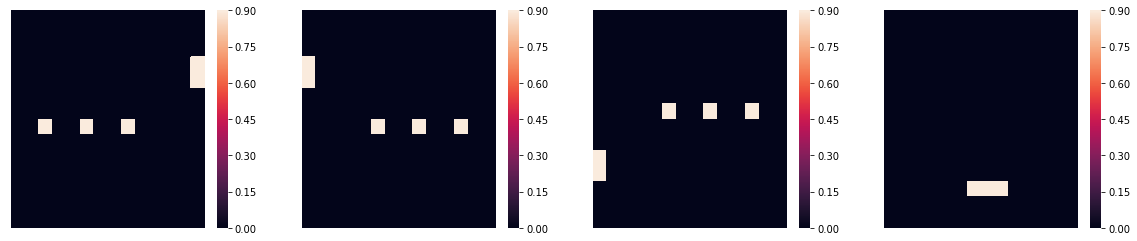

In [23]:
print("RANDOM TRAIN SAMPLES - SHOULD BE AUGMENTED")
multiplot([x.reshape(14, 14) for x in train_y[25:29]])

RANDOM TEST SAMPLES - SHOULD BE NOT AUGMENTED


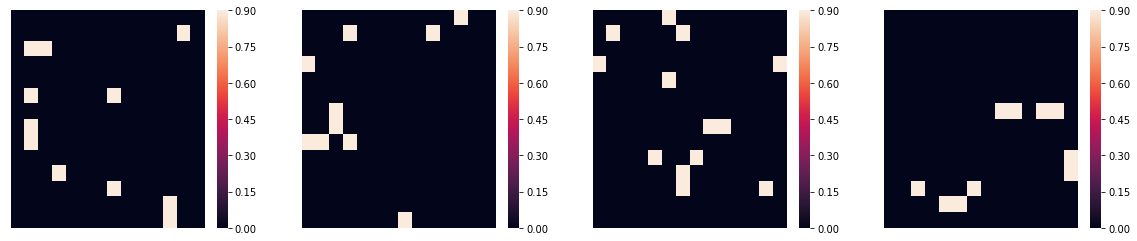

In [24]:
print("RANDOM TEST SAMPLES - SHOULD BE NOT AUGMENTED")
multiplot([x.reshape(14, 14) for x in test_y[25:29]])

# Loss definition

In [25]:
from keras.losses import binary_crossentropy
from tensorflow.python.ops import array_ops
import math

def smooth_jaccard(y_true, y_pred, smooth=1):
    y_true = tf.reshape(y_true, (-1, 14*14))
    y_pred = tf.reshape(y_pred, (-1, 14*14))
    intersection = K.sum(K.abs(y_true * y_pred), axis=-1)
    sum_ = K.sum(K.abs(y_true) + K.abs(y_pred), axis=-1)
    jac = (intersection + smooth) / (sum_ - intersection + smooth)
    return (1 - jac) * smooth

def focal_loss_fixed(y_true, y_pred, gamma = 2., alpha = 0.25):
    y_true = tf.reshape(y_true, (-1, 14*14, 1))
    y_pred = tf.reshape(y_pred, (-1, 14*14, 1))
    y_pred = K.clip(y_pred, 1e-8, 1-1e-8)
    pt_1 = tf.where(tf.equal(y_true, 1), y_pred, tf.ones_like(y_pred))
    pt_0 = tf.where(tf.equal(y_true, 0), y_pred, tf.zeros_like(y_pred))
    epsilon = K.epsilon()
        # clip to prevent NaN's and Inf's
    pt_1 = K.clip(pt_1, epsilon, 1. - epsilon)
    pt_0 = K.clip(pt_0, epsilon, 1. - epsilon)
    loss = -K.mean(alpha * 1 * K.log(K.epsilon()+pt_1)) - K.mean((1-alpha) * K.pow( pt_0, gamma) * K.log(1. - pt_0 + K.epsilon()))
    return 2 * tf.reduce_mean(loss)

def bce_jaccard(y_true, y_pred):
    jac = smooth_jaccard(y_true, y_pred)
    bce = binary_crossentropy(y_true, y_pred)
    return bce + 0.15*tf.reshape(jac, (-1, 1, 1, 1))

def weighted_bce_loss(y_true, y_pred, weight, smooth = 0.01):
    epsilon = 1e-7
    y_pred = K.clip(y_pred, epsilon, 1. - epsilon)
    logit_y_pred = K.log(y_pred / (1. - y_pred))
    #y_true = K.clip(y_true, smooth, 1. - smooth)
    loss = tf.nn.weighted_cross_entropy_with_logits(
        y_true,
        logit_y_pred,
        weight,
    )
    return tf.reduce_mean(loss)

def lovasz_foc(y_true, y_pred):
    foc_losses = []
    #bce = weighted_bce_loss(y_true, y_pred, weight = 1.3)
    foc = focal_loss_fixed(y_true, y_pred, gamma = 1.3)
    lv_image = lovasz_softmax(y_pred, tf.reshape(y_true, (-1, 14, 14)), classes=[1], per_image=True)
    return foc + 0.5 * lv_image

def lovasz(y_true, y_pred):
    lv = lovasz_softmax(y_pred, tf.reshape(y_true, (-1, 14, 14)), classes=[1], per_image=True)
    return lv

def calculate_metrics():
    best_f1 = 0
    best_thresh = 0
    p = 0
    r = 0
    error = 0
    for j in range(7, 12):
        tps = []
        fps = []
        fns = []
        perc_error = []
        trues = []
        preds = []
        val_loss = []
        for m in test_ids:
            y, vl = sess.run([fm, test_loss], feed_dict={inp: test_x[m].reshape(1, 24, 16, 16, INP_FILTERS),
                                      length: test_lengths[m].reshape(1, 1),
                                      is_training: False,
                                      labels: test_y[m, :, :].reshape(1, 14, 14),
                                      })
            true = test_y[m].reshape((14, 14))
            pred = y.reshape((14, 14))
            pred[np.where(pred > j*0.05)] = 1
            pred[np.where(pred < j*0.05)] = 0
            true_s = np.sum(true)
            pred_s = np.sum(pred)
            #true_p = true_s - (true_s - pred_s)
            perc_error.append(abs(pred_s - true_s) / 196)
            tp, fp, fn = thirty_meter(true, pred)
            tps.append(tp)
            fps.append(fp)
            fns.append(fn)
            trues.append(true_s)
            preds.append(pred_s)
            val_loss.append(np.mean(vl))
        oa_error = abs(np.sum(preds) - np.sum(trues)) / np.sum(trues)
        precision = np.sum(tps) / (np.sum(tps) + np.sum(fps))
        recall = np.sum(tps) / (np.sum(tps) + np.sum(fns))
        f1 = 2*((precision* recall) / (precision + recall))
        if f1 > best_f1:
            best_f1 = f1
            p = precision
            r = recall
            error = oa_error
            best_thresh = j*0.05
    print("Val loss: {} Thresh: {} F1: {} Recall: {} Precision: {} Error: {}".format(np.around(np.mean(val_loss), 3), np.around(best_thresh, 2),
                                                                                     np.around(best_f1, 3), np.around(p, 3), np.around(r, 3), 
                                                                                     np.around(error, 3)))
    return best_f1

In [26]:
train_ids = [x for x in range(0, len(train_y))]
print(len(train_ids))

2084


# Equibatch creation

In [27]:

def equibatch(train_ids, lovasz = False):
    first_len = 5
    second_len = 9
    third_len = 14
    np.random.shuffle(train_ids)
    ix = train_ids
    percs = [np.sum(x) for x in train_y[ix]]
    zero_ids = [x for x, z in zip(ix, percs) if z == 0]
    one_ids = [x for x, z in zip(ix, percs) if 0 < z <= first_len]
    two_ids = [x for x, z in zip(ix, percs) if first_len < z <= second_len]
    three_ids = [x for x, z in zip(ix, percs) if second_len < z <= third_len]
    four_ids = [x for x, z in zip(ix, percs) if third_len < z <= 19]
    five_ids = [x for x, z in zip(ix, percs) if 19 < z < 27]
    six_ids = [x for x, z in zip(ix, percs) if 27 < z <= 33]
    seven_ids = [x for x, z in zip(ix, percs) if 33 < z <= 41]
    eight_ids = [x for x, z in zip(ix, percs) if 41 < z <= 56]
    nine_ids =  [x for x, z in zip(ix, percs) if 56 < z <= 80]
    ten_ids =  [x for x, z in zip(ix, percs) if 80 < z <= 120]
    eleven_ids = [x for x, z in zip(ix, percs) if 120 < z]
    #ten_ids = [x for x, z in zip(ix, percs) if 125 < z]
    
    

    all_ids = [x for x in [zero_ids, one_ids, two_ids, three_ids, four_ids, five_ids, six_ids,
              seven_ids, eight_ids, nine_ids, ten_ids, eleven_ids]]
    
    new_batches = []
    maxes = [len(zero_ids), len(one_ids), len(two_ids), len(three_ids), len(four_ids),
             len(five_ids), len(six_ids), len(seven_ids), len(eight_ids), len(nine_ids), len(ten_ids), len(eleven_ids)]#, len(ten_ids)]
    cur_ids = [0] * 12
    iter_len = len(train_ids)// 16
    for i in range(0, iter_len):
        random_ids = np.random.randint(0, 12, 3)
        for i, val in enumerate(cur_ids):
            if val > maxes[i] - 5:
                cur_ids[i] = 0
        if cur_ids[0] >= (maxes[0] - 2):
            cur_ids[0] = 0
        to_append = [zero_ids[cur_ids[0]], zero_ids[cur_ids[0] + 1], one_ids[cur_ids[1]], two_ids[cur_ids[2]],
                    three_ids[cur_ids[3]], four_ids[cur_ids[4]], five_ids[cur_ids[5]],
                    six_ids[cur_ids[6]], seven_ids[cur_ids[7]], eight_ids[cur_ids[8]],
                               nine_ids[cur_ids[9]], ten_ids[cur_ids[10]], eleven_ids[cur_ids[11]],
                    all_ids[random_ids[0]][cur_ids[random_ids[0]]+1],
                     all_ids[random_ids[1]][cur_ids[random_ids[1]]+1],
                     all_ids[random_ids[2]][cur_ids[random_ids[2]]]+1]
        np.random.shuffle(to_append)
        new_batches.append(to_append)
        cur_ids = [x + 1 for x in cur_ids]
        cur_ids[0] += 1
        for x in random_ids:
            cur_ids[x] += 1
        
    new_batches = [item for sublist in new_batches for item in sublist]
    #overlap = [x for x in new_batches if x in test_ids]
    #print("There is {} overlap. Error if > 0".format(len(overlap)))
    return new_batches

In [28]:
batch = equibatch(train_ids, True)

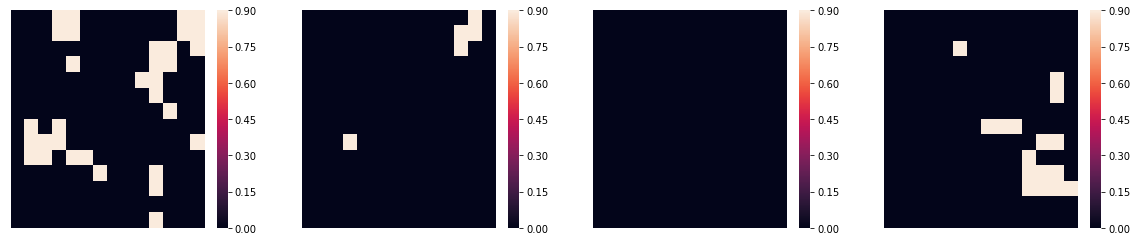

In [29]:
multiplot([x.reshape((14, 14)) for x in train_y[batch[:4]]])

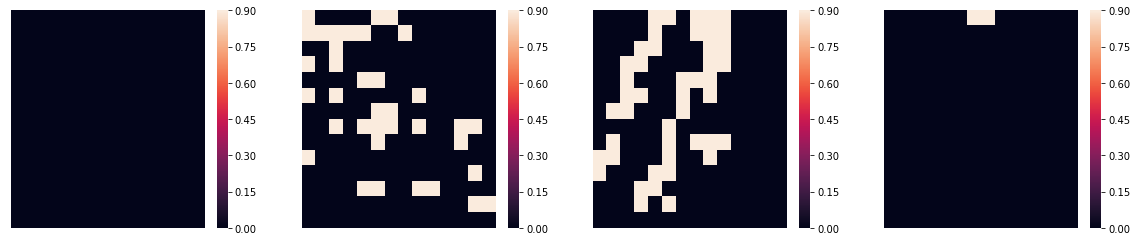

In [30]:
multiplot([x.reshape((14, 14)) for x in train_y[batch[4:8]]])

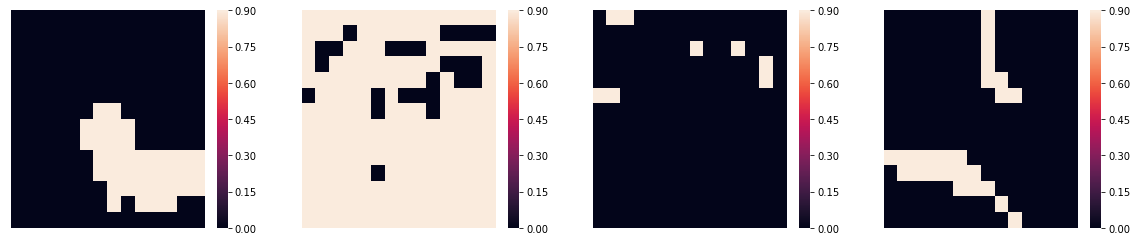

In [31]:
multiplot([x.reshape((14, 14)) for x in train_y[batch[8:12]]])

In [32]:
np.mean([np.sum(x) for x in train_y[batch]])

39.60913461538462

In [33]:
#new_saver = tf.train.import_meta_graph('../models/f1_auc/model.meta')
#new_saver.restore(sess, tf.train.latest_checkpoint('../models/f1_auc/'))

# Model training

In [181]:
FRESH_START = False
FINE_TUNE = False
from tensorflow.python.keras.optimizers import SGD
learning_rate = tf.placeholder(tf.float32, shape=[])


BATCH_SIZE = 16
print("Starting model with: \n {} zone out \n {} l2 \n {} initial LR \n {} final LR \n {} parameters"
     .format(ZONE_OUT_PROB, L2_REG, INITIAL_LR, FINAL_LR, total_parameters))
best_val = 0.620
if not FRESH_START:
    print("Resuming training with a best validation score of {}".format(best_val))
if FRESH_START:
    print("Restarting training from scratch on {} train and {} test samples, total {}".format(len(train_ids), len(test_ids), N_SAMPLES))

    optimizer = tf.train.AdamOptimizer(2e-4, epsilon = 1e-7)
    optimizer = tf.contrib.estimator.clip_gradients_by_norm(optimizer, clip_norm=1e-1)

    ft_optimizer = tf.train.AdamOptimizer(1e-4, epsilon = 1e-4)
    ft_optimizer = tf.contrib.estimator.clip_gradients_by_norm(ft_optimizer, clip_norm=0.1)
    
    train_loss = lovasz_foc(tf.reshape(labels, (-1, 14, 14, 1)), fm)
    #train_loss = focal_loss_fixed(labels, fm, gamma = 1.1, alpha = 0.5)
    test_loss = weighted_bce_loss(tf.reshape(labels, (-1, 14, 14, 1)), fm, weight = 1.)
    ft_loss = lovasz(tf.reshape(labels, (-1, 14, 14, 1)), fm)
    l2_loss = tf.losses.get_regularization_loss()
    train_loss += l2_loss
    update_ops = tf.get_collection(tf.GraphKeys.UPDATE_OPS)
    
    with tf.control_dependencies(update_ops):
        train_op = optimizer.minimize(train_loss)   
        #wu_op = wu_optimizer.minimize(wu_loss)
        ft_op = ft_optimizer.minimize(ft_loss)
    init_op = tf.global_variables_initializer()
    sess.run(init_op)
    saver = tf.train.Saver(max_to_keep = 2)

# Run training 1oop
for i in range(1, 200):
    randomize = equibatch(train_ids, lovasz = False)
    randomize = [np.min([x, len(train_y) - 1]) for x in randomize]
        #print("Loss: BCE + 0.30 Lovasz")
    op = train_op
    loss = train_loss
    #op = ft_op
    #loss = ft_loss
    BATCH_SIZE = 16
    test_ids = [x for x in range(0, len(test_x))]
    losses = []
    bce_losses = []
    
    for k in tnrange(int(len(train_ids) // BATCH_SIZE)):
        batch_ids = randomize[k*BATCH_SIZE:(k+1)*BATCH_SIZE]
        batch_y = train_y[batch_ids, :, :].reshape(len(batch_ids), 14, 14)
        opt, tr = sess.run([op, loss],
                              feed_dict={inp: train_x[batch_ids, :, :, :],
                                         length: train_l[batch_ids].reshape((-1, 1)),
                                         labels: batch_y,
                                         is_training: True,
                                         keep_rate: np.max((1 - (i*0.005), 0.85))
                                         })
        losses.append(tr)
    
    print("Epoch {}: Loss {}".format(i, np.around(np.mean(losses[:-1]), 3)))
    f1 = calculate_metrics()
    if f1 > best_val:
        best_val = f1
        print("Saving model with {}".format(f1))
        save_path = saver.save(sess, "../models/f1_auc/model")

Starting model with: 
 0.25 zone out 
 0.0 l2 
 0.0002 initial LR 
 0.001 final LR 
 67382 parameters
Resuming training with a best validation score of 0.62


Epoch 1: Loss 0.5099999904632568
Val loss: 0.30000001192092896 Thresh: 0.4 F1: 0.545 Recall: 0.549 Precision: 0.541 Error: 0.015


Epoch 2: Loss 0.5879999995231628
Val loss: 0.28600001335144043 Thresh: 0.35 F1: 0.559 Recall: 0.569 Precision: 0.549 Error: 0.036


Epoch 3: Loss 0.652999997138977
Val loss: 0.5960000157356262 Thresh: 0.55 F1: 0.5 Recall: 0.406 Precision: 0.651 Error: 0.605


Epoch 4: Loss 0.5649999976158142
Val loss: 0.41499999165534973 Thresh: 0.45 F1: 0.545 Recall: 0.518 Precision: 0.576 Error: 0.111


Epoch 5: Loss 0.6430000066757202
Val loss: 0.38100001215934753 Thresh: 0.4 F1: 0.564 Recall: 0.543 Precision: 0.587 Error: 0.082


Epoch 6: Loss 1.1380000114440918
Val loss: 1.1100000143051147 Thresh: 0.55 F1: 0.283 Recall: 0.166 Precision: 0.969 Error: 4.848


Epoch 7: Loss 0.5870000123977661
Val loss: 0.3009999990463257 Thresh: 0.35 F1: 0.529 Recall: 0.671 Precision: 0.437 Error: 0.349


Epoch 8: Loss 0.5389999747276306
Val loss: 0.4009999930858612 Thresh: 0.55 F1: 0.531 Recall: 0.493 Precision: 0.577 Error: 0.17


Epoch 9: Loss 0.47099998593330383
Val loss: 0.38499999046325684 Thresh: 0.45 F1: 0.498 Recall: 0.434 Precision: 0.583 Error: 0.342


Epoch 10: Loss 0.6600000262260437
Val loss: 0.4020000100135803 Thresh: 0.55 F1: 0.558 Recall: 0.533 Precision: 0.586 Error: 0.1


Epoch 11: Loss 0.6159999966621399
Val loss: 0.2930000126361847 Thresh: 0.4 F1: 0.534 Recall: 0.498 Precision: 0.577 Error: 0.158


Epoch 12: Loss 0.5070000290870667
Val loss: 0.5659999847412109 Thresh: 0.55 F1: 0.446 Recall: 0.312 Precision: 0.783 Error: 1.512


Epoch 13: Loss 0.5419999957084656
Val loss: 0.28999999165534973 Thresh: 0.35 F1: 0.532 Recall: 0.696 Precision: 0.43 Error: 0.382


Epoch 14: Loss 0.5759999752044678
Val loss: 0.7829999923706055 Thresh: 0.55 F1: 0.402 Recall: 0.263 Precision: 0.848 Error: 2.223


Epoch 15: Loss 0.5080000162124634
Val loss: 0.38100001215934753 Thresh: 0.5 F1: 0.568 Recall: 0.554 Precision: 0.582 Error: 0.05


Epoch 16: Loss 0.48500001430511475
Val loss: 0.27399998903274536 Thresh: 0.35 F1: 0.58 Recall: 0.556 Precision: 0.605 Error: 0.089


Epoch 17: Loss 0.5109999775886536
Val loss: 0.2849999964237213 Thresh: 0.35 F1: 0.531 Recall: 0.747 Precision: 0.412 Error: 0.449


Epoch 18: Loss 0.4869999885559082
Val loss: 0.2720000147819519 Thresh: 0.35 F1: 0.546 Recall: 0.731 Precision: 0.436 Error: 0.404


Epoch 19: Loss 0.48100000619888306
Val loss: 0.2619999945163727 Thresh: 0.35 F1: 0.571 Recall: 0.617 Precision: 0.532 Error: 0.138


Epoch 20: Loss 0.4970000088214874
Val loss: 0.3889999985694885 Thresh: 0.55 F1: 0.544 Recall: 0.442 Precision: 0.707 Error: 0.598


Epoch 21: Loss 0.5059999823570251
Val loss: 0.25999999046325684 Thresh: 0.35 F1: 0.562 Recall: 0.683 Precision: 0.477 Error: 0.301


Epoch 22: Loss 0.5400000214576721
Val loss: 1.128000020980835 Thresh: 0.55 F1: 0.376 Recall: 0.237 Precision: 0.909 Error: 2.832


Epoch 23: Loss 0.48500001430511475
Val loss: 0.2919999957084656 Thresh: 0.35 F1: 0.574 Recall: 0.568 Precision: 0.581 Error: 0.022


Epoch 24: Loss 0.4830000102519989
Val loss: 0.29899999499320984 Thresh: 0.35 F1: 0.56 Recall: 0.62 Precision: 0.51 Error: 0.178


Epoch 25: Loss 0.5070000290870667
Val loss: 0.27000001072883606 Thresh: 0.35 F1: 0.573 Recall: 0.61 Precision: 0.541 Error: 0.113


Epoch 26: Loss 0.4860000014305115
Val loss: 0.3100000023841858 Thresh: 0.35 F1: 0.513 Recall: 0.771 Precision: 0.385 Error: 0.501


Epoch 27: Loss 0.5080000162124634
Val loss: 0.25999999046325684 Thresh: 0.35 F1: 0.577 Recall: 0.691 Precision: 0.496 Error: 0.282


Epoch 28: Loss 0.5329999923706055
Val loss: 0.4000000059604645 Thresh: 0.4 F1: 0.582 Recall: 0.594 Precision: 0.571 Error: 0.04


Epoch 29: Loss 0.4729999899864197
Val loss: 0.37299999594688416 Thresh: 0.55 F1: 0.555 Recall: 0.498 Precision: 0.626 Error: 0.257


Epoch 30: Loss 0.515999972820282
Val loss: 0.33799999952316284 Thresh: 0.35 F1: 0.506 Recall: 0.593 Precision: 0.441 Error: 0.257


Epoch 31: Loss 0.5249999761581421
Val loss: 0.2770000100135803 Thresh: 0.35 F1: 0.555 Recall: 0.708 Precision: 0.457 Error: 0.355


Epoch 32: Loss 0.5230000019073486
Val loss: 0.27399998903274536 Thresh: 0.35 F1: 0.531 Recall: 0.74 Precision: 0.414 Error: 0.441


Epoch 33: Loss 0.5040000081062317
Val loss: 0.33500000834465027 Thresh: 0.5 F1: 0.576 Recall: 0.582 Precision: 0.57 Error: 0.02


Epoch 34: Loss 0.4909999966621399
Val loss: 0.26600000262260437 Thresh: 0.35 F1: 0.551 Recall: 0.743 Precision: 0.437 Error: 0.412


Epoch 35: Loss 0.5460000038146973
Val loss: 0.25699999928474426 Thresh: 0.35 F1: 0.576 Recall: 0.556 Precision: 0.597 Error: 0.073


Epoch 36: Loss 0.47999998927116394
Val loss: 0.27399998903274536 Thresh: 0.35 F1: 0.591 Recall: 0.565 Precision: 0.62 Error: 0.098


Epoch 37: Loss 0.5040000081062317
Val loss: 0.35499998927116394 Thresh: 0.45 F1: 0.561 Recall: 0.475 Precision: 0.683 Error: 0.436


Epoch 38: Loss 0.5049999952316284
Val loss: 0.2849999964237213 Thresh: 0.45 F1: 0.564 Recall: 0.503 Precision: 0.642 Error: 0.277


Epoch 39: Loss 0.5019999742507935
Val loss: 0.30000001192092896 Thresh: 0.35 F1: 0.376 Recall: 0.8 Precision: 0.245 Error: 0.693


Epoch 40: Loss 0.5339999794960022
Val loss: 0.3919999897480011 Thresh: 0.5 F1: 0.587 Recall: 0.585 Precision: 0.589 Error: 0.007


Epoch 41: Loss 0.4970000088214874
Val loss: 0.2680000066757202 Thresh: 0.35 F1: 0.546 Recall: 0.667 Precision: 0.462 Error: 0.306


Epoch 42: Loss 0.49799999594688416
Val loss: 0.27799999713897705 Thresh: 0.5 F1: 0.602 Recall: 0.58 Precision: 0.625 Error: 0.079


Epoch 43: Loss 0.5109999775886536
Val loss: 0.2460000067949295 Thresh: 0.35 F1: 0.591 Recall: 0.637 Precision: 0.55 Error: 0.136


Epoch 44: Loss 0.44200000166893005
Val loss: 0.3799999952316284 Thresh: 0.55 F1: 0.6 Recall: 0.57 Precision: 0.633 Error: 0.11


Epoch 45: Loss 0.4749999940395355
Val loss: 0.40400001406669617 Thresh: 0.55 F1: 0.561 Recall: 0.46 Precision: 0.719 Error: 0.563


Epoch 46: Loss 0.49900001287460327
Val loss: 0.27000001072883606 Thresh: 0.35 F1: 0.484 Recall: 0.795 Precision: 0.348 Error: 0.563


Epoch 47: Loss 0.49300000071525574
Val loss: 0.796999990940094 Thresh: 0.55 F1: 0.434 Recall: 0.29 Precision: 0.859 Error: 1.962


Epoch 48: Loss 0.4909999966621399
Val loss: 0.2809999883174896 Thresh: 0.45 F1: 0.563 Recall: 0.517 Precision: 0.62 Error: 0.199


Epoch 49: Loss 0.4830000102519989
Val loss: 0.37400001287460327 Thresh: 0.5 F1: 0.587 Recall: 0.564 Precision: 0.612 Error: 0.086


Epoch 50: Loss 0.46299999952316284
Val loss: 0.3440000116825104 Thresh: 0.55 F1: 0.58 Recall: 0.524 Precision: 0.649 Error: 0.239


Epoch 51: Loss 0.48399999737739563
Val loss: 0.25699999928474426 Thresh: 0.35 F1: 0.56 Recall: 0.687 Precision: 0.473 Error: 0.312


Epoch 52: Loss 0.49900001287460327
Val loss: 0.4909999966621399 Thresh: 0.55 F1: 0.566 Recall: 0.466 Precision: 0.721 Error: 0.546


Epoch 53: Loss 0.46799999475479126
Val loss: 0.26600000262260437 Thresh: 0.4 F1: 0.59 Recall: 0.578 Precision: 0.603 Error: 0.043


Epoch 54: Loss 0.47200000286102295
Val loss: 0.2630000114440918 Thresh: 0.35 F1: 0.584 Recall: 0.589 Precision: 0.58 Error: 0.015


Epoch 55: Loss 0.503000020980835
Val loss: 0.3019999861717224 Thresh: 0.4 F1: 0.583 Recall: 0.576 Precision: 0.59 Error: 0.024


Epoch 56: Loss 0.4819999933242798
Val loss: 0.44699999690055847 Thresh: 0.55 F1: 0.556 Recall: 0.499 Precision: 0.628 Error: 0.257


Epoch 57: Loss 0.460999995470047
Val loss: 0.5789999961853027 Thresh: 0.55 F1: 0.499 Recall: 0.36 Precision: 0.812 Error: 1.253


Epoch 58: Loss 0.4490000009536743
Val loss: 0.2639999985694885 Thresh: 0.45 F1: 0.598 Recall: 0.585 Precision: 0.612 Error: 0.047


Epoch 59: Loss 0.460999995470047
Val loss: 0.3720000088214874 Thresh: 0.55 F1: 0.583 Recall: 0.524 Precision: 0.657 Error: 0.255


Epoch 60: Loss 0.4650000035762787
Val loss: 0.2709999978542328 Thresh: 0.35 F1: 0.588 Recall: 0.549 Precision: 0.632 Error: 0.151


Epoch 61: Loss 0.45399999618530273
Val loss: 0.2549999952316284 Thresh: 0.4 F1: 0.596 Recall: 0.604 Precision: 0.587 Error: 0.029


Epoch 62: Loss 0.45100000500679016
Val loss: 0.6470000147819519 Thresh: 0.55 F1: 0.459 Recall: 0.312 Precision: 0.874 Error: 1.806


Epoch 63: Loss 0.4620000123977661
Val loss: 0.25699999928474426 Thresh: 0.35 F1: 0.595 Recall: 0.595 Precision: 0.596 Error: 0.002


Epoch 64: Loss 0.492000013589859
Val loss: 0.28700000047683716 Thresh: 0.35 F1: 0.434 Recall: 0.756 Precision: 0.304 Error: 0.598


Epoch 65: Loss 0.44200000166893005
Val loss: 0.2849999964237213 Thresh: 0.35 F1: 0.551 Recall: 0.625 Precision: 0.493 Error: 0.21


Epoch 66: Loss 0.45899999141693115
Val loss: 0.3179999887943268 Thresh: 0.4 F1: 0.593 Recall: 0.551 Precision: 0.643 Error: 0.166


Epoch 67: Loss 0.4490000009536743
Val loss: 0.35100001096725464 Thresh: 0.55 F1: 0.596 Recall: 0.599 Precision: 0.592 Error: 0.011


Epoch 68: Loss 0.47699999809265137
Val loss: 0.28999999165534973 Thresh: 0.35 F1: 0.485 Recall: 0.68 Precision: 0.377 Error: 0.445


Epoch 69: Loss 0.4390000104904175
Val loss: 0.28200000524520874 Thresh: 0.35 F1: 0.537 Recall: 0.696 Precision: 0.438 Error: 0.371


Epoch 70: Loss 0.43299999833106995
Val loss: 0.2919999957084656 Thresh: 0.35 F1: 0.566 Recall: 0.61 Precision: 0.528 Error: 0.135


Epoch 71: Loss 0.460999995470047
Val loss: 0.5490000247955322 Thresh: 0.55 F1: 0.539 Recall: 0.409 Precision: 0.79 Error: 0.932


Epoch 72: Loss 0.4350000023841858
Val loss: 0.41999998688697815 Thresh: 0.55 F1: 0.581 Recall: 0.495 Precision: 0.701 Error: 0.416


Epoch 73: Loss 0.43700000643730164
Val loss: 0.39100000262260437 Thresh: 0.55 F1: 0.59 Recall: 0.575 Precision: 0.605 Error: 0.053


Epoch 74: Loss 0.47099998593330383
Val loss: 0.42500001192092896 Thresh: 0.55 F1: 0.589 Recall: 0.601 Precision: 0.578 Error: 0.038


Epoch 75: Loss 0.4390000104904175
Val loss: 0.29100000858306885 Thresh: 0.35 F1: 0.569 Recall: 0.489 Precision: 0.681 Error: 0.392


Epoch 76: Loss 0.43799999356269836
Val loss: 0.39899998903274536 Thresh: 0.55 F1: 0.558 Recall: 0.482 Precision: 0.663 Error: 0.376


Epoch 77: Loss 0.4309999942779541
Val loss: 0.41200000047683716 Thresh: 0.55 F1: 0.578 Recall: 0.5 Precision: 0.685 Error: 0.37


Epoch 78: Loss 0.4580000042915344
Val loss: 0.45100000500679016 Thresh: 0.55 F1: 0.544 Recall: 0.48 Precision: 0.629 Error: 0.31


Epoch 79: Loss 0.42500001192092896
Val loss: 0.4000000059604645 Thresh: 0.55 F1: 0.546 Recall: 0.449 Precision: 0.696 Error: 0.552


Epoch 80: Loss 0.42899999022483826
Val loss: 0.43299999833106995 Thresh: 0.55 F1: 0.574 Recall: 0.473 Precision: 0.729 Error: 0.541


Epoch 81: Loss 0.4410000145435333
Val loss: 0.2939999997615814 Thresh: 0.5 F1: 0.603 Recall: 0.588 Precision: 0.62 Error: 0.054


Epoch 82: Loss 0.4320000112056732
Val loss: 0.32100000977516174 Thresh: 0.5 F1: 0.595 Recall: 0.557 Precision: 0.638 Error: 0.145


Epoch 83: Loss 0.41200000047683716
Val loss: 0.31700000166893005 Thresh: 0.5 F1: 0.568 Recall: 0.529 Precision: 0.614 Error: 0.159


Epoch 84: Loss 0.44600000977516174
Val loss: 0.3050000071525574 Thresh: 0.45 F1: 0.588 Recall: 0.525 Precision: 0.668 Error: 0.271


Epoch 85: Loss 0.421999990940094
Val loss: 0.2709999978542328 Thresh: 0.35 F1: 0.53 Recall: 0.622 Precision: 0.462 Error: 0.258


Epoch 86: Loss 0.42100000381469727
Val loss: 0.2849999964237213 Thresh: 0.4 F1: 0.603 Recall: 0.576 Precision: 0.632 Error: 0.098


Epoch 87: Loss 0.4569999873638153
Val loss: 0.27799999713897705 Thresh: 0.35 F1: 0.522 Recall: 0.632 Precision: 0.445 Error: 0.295


Epoch 88: Loss 0.42899999022483826
Val loss: 0.3019999861717224 Thresh: 0.35 F1: 0.516 Recall: 0.628 Precision: 0.438 Error: 0.302


Epoch 89: Loss 0.4339999854564667
Val loss: 0.34299999475479126 Thresh: 0.4 F1: 0.605 Recall: 0.598 Precision: 0.613 Error: 0.026


Epoch 90: Loss 0.42899999022483826
Val loss: 0.2840000092983246 Thresh: 0.35 F1: 0.565 Recall: 0.598 Precision: 0.536 Error: 0.104


Epoch 91: Loss 0.4309999942779541
Val loss: 0.3199999928474426 Thresh: 0.35 F1: 0.408 Recall: 0.725 Precision: 0.284 Error: 0.609


Epoch 92: Loss 0.4339999854564667
Val loss: 0.3840000033378601 Thresh: 0.55 F1: 0.591 Recall: 0.579 Precision: 0.604 Error: 0.044


Epoch 93: Loss 0.414000004529953
Val loss: 0.29600000381469727 Thresh: 0.35 F1: 0.586 Recall: 0.523 Precision: 0.666 Error: 0.273


Epoch 94: Loss 0.4009999930858612
Val loss: 0.32499998807907104 Thresh: 0.45 F1: 0.574 Recall: 0.599 Precision: 0.551 Error: 0.08


Epoch 95: Loss 0.4009999930858612
Val loss: 0.29499998688697815 Thresh: 0.35 F1: 0.593 Recall: 0.555 Precision: 0.636 Error: 0.146


Epoch 96: Loss 0.4189999997615814
Val loss: 0.4339999854564667 Thresh: 0.55 F1: 0.557 Recall: 0.46 Precision: 0.706 Error: 0.536


Epoch 97: Loss 0.414000004529953
Val loss: 0.2709999978542328 Thresh: 0.35 F1: 0.525 Recall: 0.648 Precision: 0.441 Error: 0.319


Epoch 98: Loss 0.41600000858306885
Val loss: 0.3310000002384186 Thresh: 0.45 F1: 0.59 Recall: 0.572 Precision: 0.609 Error: 0.064


Epoch 99: Loss 0.4050000011920929
Val loss: 0.30799999833106995 Thresh: 0.55 F1: 0.59 Recall: 0.59 Precision: 0.591 Error: 0.003


Epoch 100: Loss 0.40700000524520874
Val loss: 0.26499998569488525 Thresh: 0.35 F1: 0.573 Recall: 0.579 Precision: 0.567 Error: 0.021


Epoch 101: Loss 0.41100001335144043
Val loss: 0.42100000381469727 Thresh: 0.55 F1: 0.573 Recall: 0.505 Precision: 0.664 Error: 0.315


Epoch 102: Loss 0.41499999165534973
Val loss: 0.3400000035762787 Thresh: 0.55 F1: 0.6 Recall: 0.566 Precision: 0.639 Error: 0.13


Epoch 103: Loss 0.4009999930858612
Val loss: 0.30300000309944153 Thresh: 0.45 F1: 0.597 Recall: 0.565 Precision: 0.634 Error: 0.122


Epoch 104: Loss 0.4339999854564667
Val loss: 0.35199999809265137 Thresh: 0.55 F1: 0.591 Recall: 0.573 Precision: 0.61 Error: 0.065


Epoch 105: Loss 0.4129999876022339
Val loss: 0.27799999713897705 Thresh: 0.35 F1: 0.551 Recall: 0.592 Precision: 0.516 Error: 0.127


Epoch 106: Loss 0.40400001406669617
Val loss: 0.2750000059604645 Thresh: 0.35 F1: 0.57 Recall: 0.641 Precision: 0.513 Error: 0.199


Epoch 107: Loss 0.4090000092983246
Val loss: 0.29100000858306885 Thresh: 0.4 F1: 0.616 Recall: 0.599 Precision: 0.634 Error: 0.058


Epoch 108: Loss 0.414000004529953
Val loss: 0.29600000381469727 Thresh: 0.4 F1: 0.591 Recall: 0.584 Precision: 0.599 Error: 0.025


Epoch 109: Loss 0.39399999380111694
Val loss: 0.2919999957084656 Thresh: 0.45 F1: 0.603 Recall: 0.565 Precision: 0.647 Error: 0.146


Epoch 110: Loss 0.414000004529953
Val loss: 0.3230000138282776 Thresh: 0.55 F1: 0.581 Recall: 0.616 Precision: 0.549 Error: 0.109


Epoch 111: Loss 0.39899998903274536
Val loss: 0.26899999380111694 Thresh: 0.35 F1: 0.572 Recall: 0.516 Precision: 0.642 Error: 0.244


Epoch 112: Loss 0.4020000100135803
Val loss: 0.35899999737739563 Thresh: 0.55 F1: 0.588 Recall: 0.569 Precision: 0.608 Error: 0.069


Epoch 113: Loss 0.40299999713897705
Val loss: 0.35100001096725464 Thresh: 0.55 F1: 0.58 Recall: 0.552 Precision: 0.611 Error: 0.106


Epoch 114: Loss 0.42100000381469727
Val loss: 0.32100000977516174 Thresh: 0.45 F1: 0.591 Recall: 0.616 Precision: 0.567 Error: 0.079


Epoch 115: Loss 0.40299999713897705
Val loss: 0.3070000112056732 Thresh: 0.45 F1: 0.592 Recall: 0.578 Precision: 0.607 Error: 0.049


Epoch 116: Loss 0.41100001335144043
Val loss: 0.41200000047683716 Thresh: 0.55 F1: 0.571 Recall: 0.562 Precision: 0.581 Error: 0.034


Epoch 117: Loss 0.41200000047683716
Val loss: 0.29100000858306885 Thresh: 0.35 F1: 0.585 Recall: 0.569 Precision: 0.601 Error: 0.056


Epoch 118: Loss 0.40799999237060547
Val loss: 0.2709999978542328 Thresh: 0.35 F1: 0.486 Recall: 0.707 Precision: 0.37 Error: 0.476


Epoch 119: Loss 0.40299999713897705
Val loss: 0.3179999887943268 Thresh: 0.55 F1: 0.611 Recall: 0.587 Precision: 0.637 Error: 0.085


Epoch 120: Loss 0.40799999237060547
Val loss: 0.29600000381469727 Thresh: 0.4 F1: 0.586 Recall: 0.573 Precision: 0.601 Error: 0.05


Epoch 121: Loss 0.3970000147819519
Val loss: 0.3569999933242798 Thresh: 0.55 F1: 0.579 Recall: 0.592 Precision: 0.567 Error: 0.042


Epoch 122: Loss 0.4050000011920929
Val loss: 0.2840000092983246 Thresh: 0.45 F1: 0.597 Recall: 0.586 Precision: 0.61 Error: 0.041


Epoch 123: Loss 0.39899998903274536
Val loss: 0.382999986410141 Thresh: 0.55 F1: 0.582 Recall: 0.59 Precision: 0.574 Error: 0.028


Epoch 124: Loss 0.4189999997615814
Val loss: 0.2709999978542328 Thresh: 0.35 F1: 0.471 Recall: 0.667 Precision: 0.364 Error: 0.454


Epoch 125: Loss 0.4009999930858612
Val loss: 0.2840000092983246 Thresh: 0.4 F1: 0.574 Recall: 0.519 Precision: 0.642 Error: 0.239


Epoch 126: Loss 0.39800000190734863
Val loss: 0.2919999957084656 Thresh: 0.35 F1: 0.598 Recall: 0.53 Precision: 0.685 Error: 0.294


Epoch 127: Loss 0.3970000147819519
Val loss: 0.3310000002384186 Thresh: 0.5 F1: 0.601 Recall: 0.613 Precision: 0.59 Error: 0.038


Epoch 128: Loss 0.39100000262260437
Val loss: 0.28999999165534973 Thresh: 0.35 F1: 0.57 Recall: 0.57 Precision: 0.57 Error: 0.001


Epoch 129: Loss 0.3790000081062317
Val loss: 0.33000001311302185 Thresh: 0.5 F1: 0.58 Recall: 0.538 Precision: 0.63 Error: 0.17


Epoch 130: Loss 0.4059999883174896
Val loss: 0.3779999911785126 Thresh: 0.55 F1: 0.612 Recall: 0.602 Precision: 0.623 Error: 0.035


Epoch 131: Loss 0.38100001215934753
Val loss: 0.2919999957084656 Thresh: 0.4 F1: 0.572 Recall: 0.52 Precision: 0.635 Error: 0.221


Epoch 132: Loss 0.3869999945163727
Val loss: 0.3529999852180481 Thresh: 0.55 F1: 0.598 Recall: 0.563 Precision: 0.638 Error: 0.134


Epoch 133: Loss 0.3889999985694885
Val loss: 0.3370000123977661 Thresh: 0.5 F1: 0.6 Recall: 0.584 Precision: 0.618 Error: 0.058


Epoch 134: Loss 0.4000000059604645
Val loss: 0.26600000262260437 Thresh: 0.35 F1: 0.596 Recall: 0.601 Precision: 0.592 Error: 0.014


Epoch 135: Loss 0.39399999380111694
Val loss: 0.29100000858306885 Thresh: 0.4 F1: 0.573 Recall: 0.553 Precision: 0.595 Error: 0.074


Epoch 136: Loss 0.3720000088214874
Val loss: 0.289000004529953 Thresh: 0.45 F1: 0.584 Recall: 0.586 Precision: 0.581 Error: 0.008


Epoch 137: Loss 0.42100000381469727
Val loss: 0.289000004529953 Thresh: 0.35 F1: 0.578 Recall: 0.551 Precision: 0.607 Error: 0.101


Epoch 138: Loss 0.3919999897480011
Val loss: 0.30000001192092896 Thresh: 0.4 F1: 0.575 Recall: 0.508 Precision: 0.663 Error: 0.304


Epoch 139: Loss 0.3930000066757202
Val loss: 0.2800000011920929 Thresh: 0.35 F1: 0.576 Recall: 0.562 Precision: 0.59 Error: 0.049


Epoch 140: Loss 0.38499999046325684
Val loss: 0.2619999945163727 Thresh: 0.35 F1: 0.578 Recall: 0.585 Precision: 0.572 Error: 0.022


Epoch 141: Loss 0.3779999911785126
Val loss: 0.3009999990463257 Thresh: 0.45 F1: 0.587 Recall: 0.57 Precision: 0.606 Error: 0.064


Epoch 142: Loss 0.39899998903274536
Val loss: 0.28999999165534973 Thresh: 0.35 F1: 0.58 Recall: 0.537 Precision: 0.63 Error: 0.173


Epoch 143: Loss 0.39899998903274536
Val loss: 0.2709999978542328 Thresh: 0.45 F1: 0.58 Recall: 0.563 Precision: 0.599 Error: 0.064


Epoch 144: Loss 0.382999986410141
Val loss: 0.3799999952316284 Thresh: 0.55 F1: 0.588 Recall: 0.497 Precision: 0.72 Error: 0.448


Epoch 145: Loss 0.4000000059604645
Val loss: 0.2800000011920929 Thresh: 0.4 F1: 0.586 Recall: 0.563 Precision: 0.611 Error: 0.086


Epoch 146: Loss 0.40799999237060547
Val loss: 0.4359999895095825 Thresh: 0.55 F1: 0.573 Recall: 0.482 Precision: 0.706 Error: 0.464


Epoch 147: Loss 0.38999998569488525
Val loss: 0.289000004529953 Thresh: 0.35 F1: 0.563 Recall: 0.613 Precision: 0.52 Error: 0.153


Epoch 148: Loss 0.3840000033378601
Val loss: 0.2800000011920929 Thresh: 0.4 F1: 0.6 Recall: 0.579 Precision: 0.623 Error: 0.076


Epoch 149: Loss 0.38499999046325684
Val loss: 0.26499998569488525 Thresh: 0.35 F1: 0.484 Recall: 0.719 Precision: 0.365 Error: 0.492


Epoch 150: Loss 0.38100001215934753
Val loss: 0.3199999928474426 Thresh: 0.55 F1: 0.617 Recall: 0.617 Precision: 0.616 Error: 0.002


Epoch 151: Loss 0.3790000081062317
Val loss: 0.26899999380111694 Thresh: 0.35 F1: 0.558 Recall: 0.525 Precision: 0.595 Error: 0.132


Epoch 152: Loss 0.3889999985694885
Val loss: 0.2619999945163727 Thresh: 0.35 F1: 0.581 Recall: 0.543 Precision: 0.625 Error: 0.15


Epoch 153: Loss 0.36899998784065247
Val loss: 0.39399999380111694 Thresh: 0.55 F1: 0.58 Recall: 0.521 Precision: 0.655 Error: 0.258


Epoch 154: Loss 0.3889999985694885
Val loss: 0.30799999833106995 Thresh: 0.55 F1: 0.591 Recall: 0.589 Precision: 0.592 Error: 0.006


Epoch 155: Loss 0.37599998712539673
Val loss: 0.24899999797344208 Thresh: 0.35 F1: 0.571 Recall: 0.624 Precision: 0.526 Error: 0.158


Epoch 156: Loss 0.37599998712539673
Val loss: 0.3160000145435333 Thresh: 0.45 F1: 0.591 Recall: 0.566 Precision: 0.617 Error: 0.091


Epoch 157: Loss 0.382999986410141
Val loss: 0.2669999897480011 Thresh: 0.45 F1: 0.603 Recall: 0.609 Precision: 0.597 Error: 0.02


Epoch 158: Loss 0.38499999046325684
Val loss: 0.26600000262260437 Thresh: 0.35 F1: 0.511 Recall: 0.727 Precision: 0.394 Error: 0.458


Epoch 159: Loss 0.3959999978542328
Val loss: 0.3019999861717224 Thresh: 0.45 F1: 0.578 Recall: 0.525 Precision: 0.644 Error: 0.226


Epoch 160: Loss 0.3720000088214874
Val loss: 0.33399999141693115 Thresh: 0.5 F1: 0.589 Recall: 0.596 Precision: 0.582 Error: 0.024


Epoch 161: Loss 0.3840000033378601
Val loss: 0.26499998569488525 Thresh: 0.35 F1: 0.502 Recall: 0.692 Precision: 0.394 Error: 0.43


Epoch 162: Loss 0.38100001215934753
Val loss: 0.30300000309944153 Thresh: 0.4 F1: 0.558 Recall: 0.503 Precision: 0.626 Error: 0.245


Epoch 163: Loss 0.382999986410141
Val loss: 0.2669999897480011 Thresh: 0.35 F1: 0.581 Recall: 0.579 Precision: 0.584 Error: 0.008


Epoch 164: Loss 0.37599998712539673
Val loss: 0.2529999911785126 Thresh: 0.35 F1: 0.563 Recall: 0.672 Precision: 0.484 Error: 0.281


Epoch 165: Loss 0.3790000081062317
Val loss: 0.26899999380111694 Thresh: 0.35 F1: 0.587 Recall: 0.549 Precision: 0.63 Error: 0.147


Epoch 166: Loss 0.37599998712539673
Val loss: 0.2980000078678131 Thresh: 0.35 F1: 0.574 Recall: 0.576 Precision: 0.573 Error: 0.005


Epoch 167: Loss 0.38600000739097595
Val loss: 0.3050000071525574 Thresh: 0.5 F1: 0.599 Recall: 0.579 Precision: 0.619 Error: 0.07


Epoch 168: Loss 0.3720000088214874
Val loss: 0.2980000078678131 Thresh: 0.4 F1: 0.578 Recall: 0.534 Precision: 0.63 Error: 0.179


Epoch 169: Loss 0.35899999737739563
Val loss: 0.2630000114440918 Thresh: 0.4 F1: 0.604 Recall: 0.572 Precision: 0.639 Error: 0.118


Epoch 170: Loss 0.36500000953674316
Val loss: 0.2879999876022339 Thresh: 0.5 F1: 0.603 Recall: 0.584 Precision: 0.624 Error: 0.068


Epoch 171: Loss 0.36500000953674316
Val loss: 0.257999986410141 Thresh: 0.35 F1: 0.576 Recall: 0.582 Precision: 0.57 Error: 0.02


Epoch 172: Loss 0.36800000071525574
Val loss: 0.2709999978542328 Thresh: 0.35 F1: 0.601 Recall: 0.585 Precision: 0.617 Error: 0.054


Epoch 173: Loss 0.3659999966621399
Val loss: 0.2770000100135803 Thresh: 0.35 F1: 0.521 Recall: 0.631 Precision: 0.443 Error: 0.298


Epoch 174: Loss 0.3720000088214874
Val loss: 0.2879999876022339 Thresh: 0.45 F1: 0.578 Recall: 0.566 Precision: 0.589 Error: 0.04


Epoch 175: Loss 0.3659999966621399
Val loss: 0.2460000067949295 Thresh: 0.35 F1: 0.589 Recall: 0.639 Precision: 0.547 Error: 0.144


Epoch 176: Loss 0.3720000088214874
Val loss: 0.29499998688697815 Thresh: 0.45 F1: 0.596 Recall: 0.573 Precision: 0.622 Error: 0.085


Epoch 177: Loss 0.36399999260902405
Val loss: 0.26600000262260437 Thresh: 0.45 F1: 0.606 Recall: 0.583 Precision: 0.63 Error: 0.079


Epoch 178: Loss 0.36000001430511475
Val loss: 0.24899999797344208 Thresh: 0.35 F1: 0.576 Recall: 0.638 Precision: 0.524 Error: 0.178


Epoch 179: Loss 0.3799999952316284
Val loss: 0.32899999618530273 Thresh: 0.5 F1: 0.591 Recall: 0.548 Precision: 0.641 Error: 0.168


Epoch 180: Loss 0.36899998784065247
Val loss: 0.26600000262260437 Thresh: 0.35 F1: 0.59 Recall: 0.557 Precision: 0.627 Error: 0.127


Epoch 181: Loss 0.3659999966621399
Val loss: 0.3310000002384186 Thresh: 0.55 F1: 0.58 Recall: 0.587 Precision: 0.573 Error: 0.023


Epoch 182: Loss 0.3790000081062317
Val loss: 0.26100000739097595 Thresh: 0.35 F1: 0.59 Recall: 0.577 Precision: 0.604 Error: 0.047


Epoch 183: Loss 0.3610000014305115
Val loss: 0.24899999797344208 Thresh: 0.35 F1: 0.56 Recall: 0.656 Precision: 0.488 Error: 0.257


Epoch 184: Loss 0.36899998784065247
Val loss: 0.3089999854564667 Thresh: 0.55 F1: 0.604 Recall: 0.631 Precision: 0.579 Error: 0.083


Epoch 185: Loss 0.3569999933242798
Val loss: 0.2709999978542328 Thresh: 0.35 F1: 0.568 Recall: 0.556 Precision: 0.581 Error: 0.045


Epoch 186: Loss 0.36800000071525574
Val loss: 0.24699999392032623 Thresh: 0.4 F1: 0.594 Recall: 0.617 Precision: 0.573 Error: 0.071


Epoch 187: Loss 0.3580000102519989
Val loss: 0.32100000977516174 Thresh: 0.5 F1: 0.588 Recall: 0.574 Precision: 0.603 Error: 0.051


Epoch 188: Loss 0.36500000953674316
Val loss: 0.26100000739097595 Thresh: 0.35 F1: 0.574 Recall: 0.547 Precision: 0.604 Error: 0.106


Epoch 189: Loss 0.3569999933242798
Val loss: 0.3160000145435333 Thresh: 0.5 F1: 0.603 Recall: 0.57 Precision: 0.641 Error: 0.124


Epoch 190: Loss 0.36000001430511475
Val loss: 0.2549999952316284 Thresh: 0.35 F1: 0.551 Recall: 0.625 Precision: 0.492 Error: 0.212


Epoch 191: Loss 0.3580000102519989
Val loss: 0.24699999392032623 Thresh: 0.35 F1: 0.592 Recall: 0.592 Precision: 0.593 Error: 0.003


Epoch 192: Loss 0.3659999966621399
Val loss: 0.28200000524520874 Thresh: 0.45 F1: 0.589 Recall: 0.563 Precision: 0.617 Error: 0.094


Epoch 193: Loss 0.3619999885559082
Val loss: 0.2680000066757202 Thresh: 0.35 F1: 0.568 Recall: 0.541 Precision: 0.598 Error: 0.106


Epoch 194: Loss 0.3709999918937683
Val loss: 0.2919999957084656 Thresh: 0.45 F1: 0.595 Recall: 0.598 Precision: 0.592 Error: 0.011


Epoch 195: Loss 0.35600000619888306
Val loss: 0.27000001072883606 Thresh: 0.4 F1: 0.602 Recall: 0.581 Precision: 0.624 Error: 0.074


Epoch 196: Loss 0.3619999885559082
Val loss: 0.3059999942779541 Thresh: 0.45 F1: 0.597 Recall: 0.554 Precision: 0.649 Error: 0.172


Epoch 197: Loss 0.36500000953674316
Val loss: 0.24799999594688416 Thresh: 0.35 F1: 0.583 Recall: 0.626 Precision: 0.546 Error: 0.128


Epoch 198: Loss 0.35600000619888306
Val loss: 0.3319999873638153 Thresh: 0.45 F1: 0.609 Recall: 0.586 Precision: 0.633 Error: 0.08


Epoch 199: Loss 0.3700000047683716
Val loss: 0.27799999713897705 Thresh: 0.35 F1: 0.52 Recall: 0.645 Precision: 0.435 Error: 0.325


# Model validation and sanity checks





In [182]:
start = 0
test_ids = [x for x in range(0, len(test_x))]

def multiplot(matrices, nrows = 2, ncols = 4):
    '''Plot multiple heatmaps with subplots'''
    fig, axs = plt.subplots(ncols=4, nrows = nrows)
    fig.set_size_inches(20, 4*nrows)
    to_iter = [[x for x in range(i, i + ncols + 1)] for i in range(0, nrows*ncols, ncols)]
    for r in range(1, nrows + 1):
        min_i = min(to_iter[r-1])
        max_i = max(to_iter[r-1])
        for i, matrix in enumerate(matrices[min_i:max_i]):
            sns.heatmap(data = matrix, ax = axs[r - 1, i], vmin = 0, vmax = 0.9)
            axs[r - 1, i].set_xlabel("")
            axs[r - 1, i].set_ylabel("")
            axs[r - 1, i].set_yticks([])
            axs[r - 1, i].set_xticks([])
    plt.show()
start = 15




0.4244604316546763
59
60
61
62
63
64
65
66


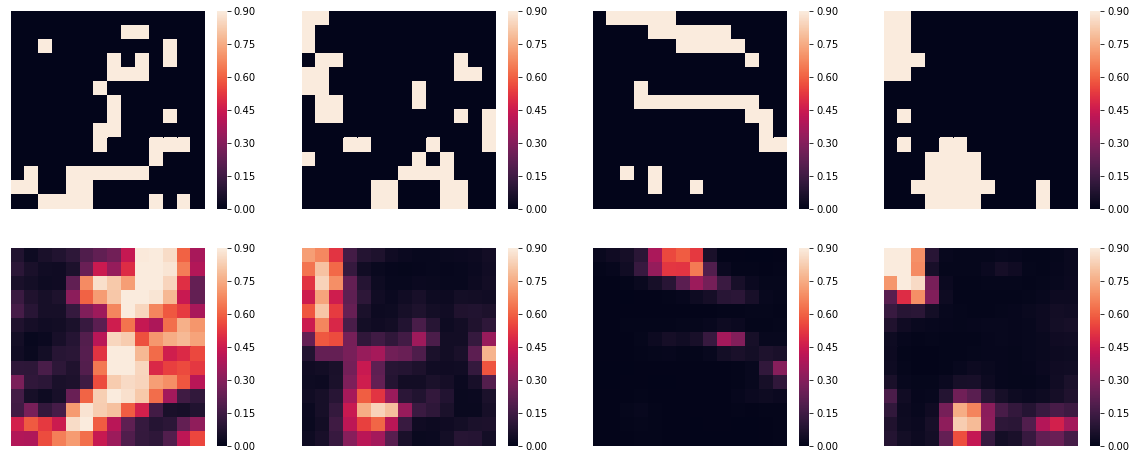

In [194]:
import random 

    
test_losses = []
print(start/len(test_ids))
test_ids = sorted(test_ids)
matrix_ids = [test_ids[start], test_ids[start + 1], test_ids[start + 2], test_ids[start + 3],
              test_ids[start + 4], test_ids[start + 5], test_ids[start + 6], test_ids[start + 7]]
#matrix_ids = random.sample(test_ids, 4)z

preds = []
trues = []
for i in matrix_ids:
    idx = i
    print(i)
    y = sess.run([fm], feed_dict={inp: test_x[idx].reshape(1, 24, IMAGE_SIZE, IMAGE_SIZE, INP_FILTERS),
                                  length: test_lengths[idx].reshape(1, 1),
                                  is_training: False,
                                  })
    y = np.array(y).reshape(14, 14)
    preds.append(y)
    true = test_y[idx].reshape(LABEL_SIZE, LABEL_SIZE)
    trues.append(true)
    
to_plot = trues[0:4] + preds[0:4]# + trues[5:] + preds[5:]
multiplot(to_plot, nrows = 2, ncols = 4)
#plot_ids[ordering[976]//4] 

start = start+ 4


0.16546762589928057
1331
120
814
1844


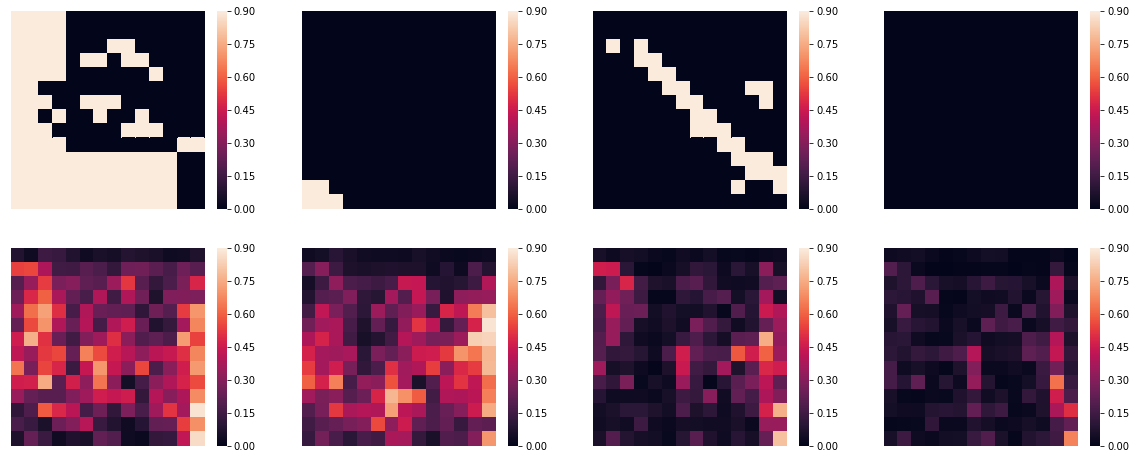

In [76]:
import random 

    
test_losses = []
print(start/len(test_ids))
test_ids = sorted(test_ids)
#matrix_ids = [test_ids[start], test_ids[start + 1], test_ids[start + 2], test_ids[start + 3],
#              test_ids[start + 4], test_ids[start + 5], test_ids[start + 6], test_ids[start + 7]]
matrix_ids = random.sample(train_ids, 4)

preds = []
trues = []
for i in matrix_ids:
    idx = i
    print(i)
    y = sess.run([fm], feed_dict={inp: train_x[idx].reshape(1, 24, IMAGE_SIZE, IMAGE_SIZE, INP_FILTERS),
                                  length: train_l[idx].reshape(1, 1),
                                  is_training: False,
                                  })
    y = np.array(y).reshape(14, 14)
    preds.append(y)
    true = train_y[idx].reshape(LABEL_SIZE, LABEL_SIZE)
    trues.append(true)
    

to_plot = trues[0:4] + preds[0:4]# + trues[5:] + preds[5:]
multiplot(to_plot, nrows = 2, ncols = 4)
#plot_ids[ordering[976]//4] 
start = start + 4

In [71]:
plot_ids2 = [val for x, val in enumerate(plot_ids) if x not in list(set([x // 4 for x in outliers]))]
plot_ids2[ordering[460]//4] 

135191331

# Calculate ROC for best threshold selection

In [167]:
calculate_metrics()

Val loss: 0.27000001072883606 Thresh: 0.35 F1: 0.569 Recall: 0.577 Precision: 0.56 Error: 0.03


0.5686440677966103

## TODO @jombrandt top 10 worst training, test samples by IOU 

These should be written to a tmp/ .txt file and indexed by validate-data.ipynb to ensure that original classifications were correct, and to identify regions that need more training data.